# Enterprise Deep Learning with TensorFlow: OpenSAP 

## SAP Innovation Center Network
```
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

### Need for Deeper Networks

In this notebook, we provide an experimental framework for understanding how deeper networks and non-linearities model the data better. For this task, we use the Fashion MNIST data from https://github.com/zalandoresearch/fashion-mnist
The main task of this data is to classify fashion images into 10 different classes.
For our experiments, we will train the following configurations of networks

- A single-layer neural network with no activation
- A single-layer neural network with ReLU activation
- A three-layer neural network with ReLU activation

In [1]:
# create data/fashion folder, if it doesn't exist
import os
if not os.path.exists("data/fashion"):
    os.makedirs("data/fashion")
    
# Download the labels from the Fashion MNIST data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz --directory-prefix=./data/fashion/
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz --directory-prefix=./data/fashion/
# Download the images from the Fashion MNIST data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz --directory-prefix=./data/fashion/
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz --directory-prefix=./data/fashion/

--2017-11-05 16:54:38--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com... 52.219.74.23
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com|52.219.74.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29515 (29K) [binary/octet-stream]
Saving to: './data/fashion/train-labels-idx1-ubyte.gz.2'

train-labels-idx1-u 100%[===================>]  28.82K  --.-KB/s    in 0.02s   

2017-11-05 16:54:38 (1.18 MB/s) - './data/fashion/train-labels-idx1-ubyte.gz.2' saved [29515/29515]

--2017-11-05 16:54:38--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com... 52.219.74.23
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com|52.219.74.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5148 (5.0K) [binary/octet-stream]
Saving to: 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

fash_data = input_data.read_data_sets('data/fashion')

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [3]:
# Train and test images
X_train = fash_data.train.images
X_test = fash_data.test.images

# Train and test labels
y_train = fash_data.train.labels.astype("int")
y_test = fash_data.test.labels.astype("int")

In [4]:
# View some input data from the dataset
from matplotlib import pyplot as plt
from random import randint
import numpy as np
%matplotlib inline

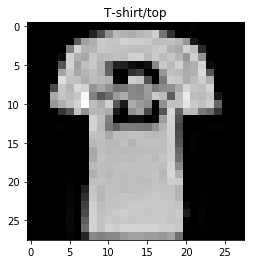

In [5]:
def gen_image(arr, im_title):
    image_data = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.title(im_title)
    plt.imshow(image_data, interpolation='nearest', cmap='gray')
    return plt

fash_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Produces a new image for each run
im_index = randint(0, 100)
batch_X, batch_y = fash_data.test.next_batch(100)
gen_image(batch_X[im_index], fash_labels[batch_y[im_index]]).show()

In [6]:
import tensorflow as tf
import numpy as np

num_inputs = 28*28  # Fashion MNIST
num_outputs = 10

num_hidden_1 = 300
num_hidden_2 = 100
num_hidden_3 = 100

In [7]:
# Reset graph and set seed to produce reproducible results across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, num_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [8]:
# Define a hidden layer method that creates a name scope in the TF graph
def hidden_layer(X, num_neurons, name, activation=None):
    # Use a name scope to clearly separate the layers on TensorBoard
    with tf.name_scope(name):
        num_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(num_inputs)
        # Initialize the weights with truncated normal and standard deviation from input data
        init = tf.truncated_normal((num_inputs, num_neurons), stddev=stddev)
        # Weights and bias
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([num_neurons]), name="bias")
        # Output
        Z = tf.matmul(X, W) + b
        # Support for returning values with and without non-linearity
        if activation is not None:
            Z = activation(Z)
            
        return Z

In [9]:
# Defining a one-layer neural network with no non-linearities
with tf.name_scope("onelayer_nn"):
    hidden_layer_1 = hidden_layer(X, num_neurons=num_hidden_1, name="hidden_layer_1", activation=None)
    logits = hidden_layer(hidden_layer_1, num_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [10]:
# Define the initialization and saver for saving our model to local file system
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [11]:
# Define the number of epochs and batch size 
num_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(num_epochs):
        # Train the network by feeding in batch_size examples for each iteration
        for iteration in range(fash_data.train.num_examples // batch_size):
            X_batch, y_batch = fash_data.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        # Evaluate test data after every epoch
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: fash_data.test.images, y: fash_data.test.labels})
        
        # Log some results
        print("Epoch:", epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./single_layer_model.ckpt")

Epoch: 0 Train accuracy: 0.76 Test accuracy: 0.8025
Epoch: 1 Train accuracy: 0.86 Test accuracy: 0.8187
Epoch: 2 Train accuracy: 0.9 Test accuracy: 0.8225
Epoch: 3 Train accuracy: 0.8 Test accuracy: 0.8298
Epoch: 4 Train accuracy: 0.8 Test accuracy: 0.831
Epoch: 5 Train accuracy: 0.88 Test accuracy: 0.8284
Epoch: 6 Train accuracy: 0.84 Test accuracy: 0.8363
Epoch: 7 Train accuracy: 0.84 Test accuracy: 0.8362
Epoch: 8 Train accuracy: 0.82 Test accuracy: 0.8386
Epoch: 9 Train accuracy: 0.86 Test accuracy: 0.8397
Epoch: 10 Train accuracy: 0.9 Test accuracy: 0.8323
Epoch: 11 Train accuracy: 0.9 Test accuracy: 0.8393
Epoch: 12 Train accuracy: 0.86 Test accuracy: 0.839
Epoch: 13 Train accuracy: 0.92 Test accuracy: 0.8385
Epoch: 14 Train accuracy: 0.86 Test accuracy: 0.8381
Epoch: 15 Train accuracy: 0.92 Test accuracy: 0.8381
Epoch: 16 Train accuracy: 0.88 Test accuracy: 0.8414
Epoch: 17 Train accuracy: 0.84 Test accuracy: 0.841
Epoch: 18 Train accuracy: 0.9 Test accuracy: 0.8369
Epoch: 19 Tr

INFO:tensorflow:Restoring parameters from ./single_layer_model.ckpt


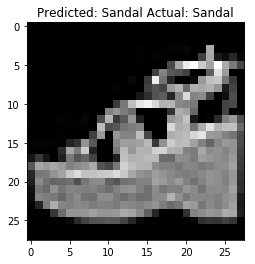

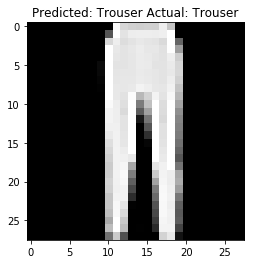

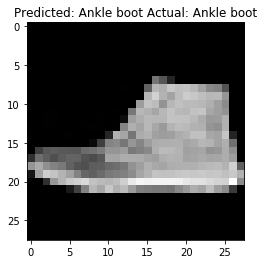

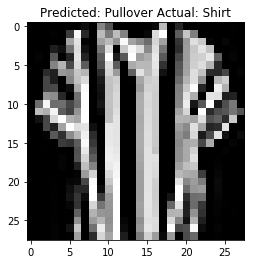

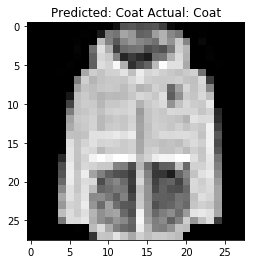

In [12]:
# Evaluate the single-layer neural network
with tf.Session() as sess:
    saver.restore(sess, "./single_layer_model.ckpt") 
    X_new_scaled = fash_data.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

for im_index in range(5):
    gen_image(fash_data.test.images[im_index], 
              "Predicted: %s Actual: %s" % (fash_labels[y_pred[im_index]], 
                                           fash_labels[fash_data.test.labels[im_index]])).show()


In [13]:
# Defining a one layer neural network with ReLU non-linearity
with tf.name_scope("onelayer_nn_relu"):
    hidden_layer_1 = hidden_layer(X, num_neurons=num_hidden_1, name="hidden_layer_1", activation=tf.nn.relu)
    logits = hidden_layer(hidden_layer_1, num_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [14]:
# Define the initialization and saver for saving our model to local file system
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:
# Define the number of epochs and batch size 
num_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(num_epochs):
        # Train the network by feeding in batch_size examples for each iteration
        for iteration in range(fash_data.train.num_examples // batch_size):
            X_batch, y_batch = fash_data.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        # Evaluate test data after every epoch
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: fash_data.test.images, y: fash_data.test.labels})
        
        # Log some results
        print("Epoch:", epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./single_layer_model_with_relu.ckpt")

Epoch: 0 Train accuracy: 0.86 Test accuracy: 0.8023
Epoch: 1 Train accuracy: 0.84 Test accuracy: 0.8232
Epoch: 2 Train accuracy: 0.88 Test accuracy: 0.8282
Epoch: 3 Train accuracy: 0.86 Test accuracy: 0.8364
Epoch: 4 Train accuracy: 0.82 Test accuracy: 0.8414
Epoch: 5 Train accuracy: 0.86 Test accuracy: 0.8463
Epoch: 6 Train accuracy: 0.88 Test accuracy: 0.8464
Epoch: 7 Train accuracy: 0.82 Test accuracy: 0.8477
Epoch: 8 Train accuracy: 0.82 Test accuracy: 0.848
Epoch: 9 Train accuracy: 0.94 Test accuracy: 0.8491
Epoch: 10 Train accuracy: 0.92 Test accuracy: 0.8543
Epoch: 11 Train accuracy: 0.96 Test accuracy: 0.8544
Epoch: 12 Train accuracy: 0.9 Test accuracy: 0.8576
Epoch: 13 Train accuracy: 0.96 Test accuracy: 0.8558
Epoch: 14 Train accuracy: 0.88 Test accuracy: 0.8571
Epoch: 15 Train accuracy: 0.92 Test accuracy: 0.8602
Epoch: 16 Train accuracy: 0.92 Test accuracy: 0.8569
Epoch: 17 Train accuracy: 0.84 Test accuracy: 0.863
Epoch: 18 Train accuracy: 0.84 Test accuracy: 0.8608
Epoch:

INFO:tensorflow:Restoring parameters from ./single_layer_model_with_relu.ckpt


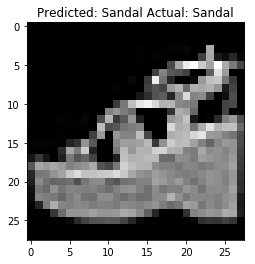

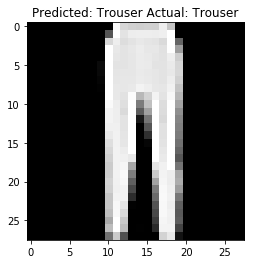

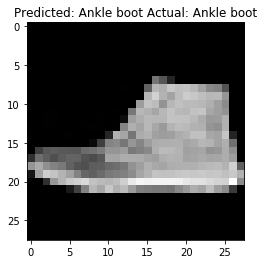

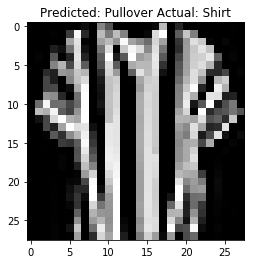

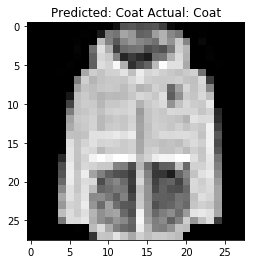

In [16]:
# Evaluate the single layer network with relu
with tf.Session() as sess:
    saver.restore(sess, "./single_layer_model_with_relu.ckpt") 
    X_new_scaled = fash_data.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

for im_index in range(5):
    gen_image(fash_data.test.images[im_index], 
              "Predicted: %s Actual: %s" % (fash_labels[y_pred[im_index]], 
                                           fash_labels[fash_data.test.labels[im_index]])).show()


In [17]:
# Defining a three-layer neural network with ReLU non-linearity
with tf.name_scope("threelayer_nn_relu"):
    hidden_layer_1 = hidden_layer(X, num_neurons=num_hidden_1, name="hidden_layer_1", activation=tf.nn.relu)
    hidden_layer_2 = hidden_layer(hidden_layer_1, num_neurons=num_hidden_2, name="hidden_layer_2", 
                                  activation=tf.nn.relu)
    hidden_layer_3 = hidden_layer(hidden_layer_2, num_neurons=num_hidden_3, name="hidden_layer_3", 
                                  activation=tf.nn.relu)
    logits = hidden_layer(hidden_layer_3, num_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [18]:
# Define the initialization and saver for saving our model to local file system
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [19]:
# Define the number of epochs and batch size 
num_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(num_epochs):
        # Train the network by feeding in batch_size examples for each iteration
        for iteration in range(fash_data.train.num_examples // batch_size):
            X_batch, y_batch = fash_data.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        # Evaluate test data after every epoch
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: fash_data.test.images, y: fash_data.test.labels})
        
        # Log some results
        print("Epoch:", epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./three_layer_model_with_relu.ckpt")

Epoch: 0 Train accuracy: 0.86 Test accuracy: 0.8224
Epoch: 1 Train accuracy: 0.92 Test accuracy: 0.8354
Epoch: 2 Train accuracy: 0.94 Test accuracy: 0.8468
Epoch: 3 Train accuracy: 0.88 Test accuracy: 0.8521
Epoch: 4 Train accuracy: 0.86 Test accuracy: 0.8518
Epoch: 5 Train accuracy: 0.92 Test accuracy: 0.8626
Epoch: 6 Train accuracy: 0.88 Test accuracy: 0.8618
Epoch: 7 Train accuracy: 0.88 Test accuracy: 0.8617
Epoch: 8 Train accuracy: 0.86 Test accuracy: 0.8652
Epoch: 9 Train accuracy: 0.94 Test accuracy: 0.8665
Epoch: 10 Train accuracy: 0.82 Test accuracy: 0.872
Epoch: 11 Train accuracy: 0.94 Test accuracy: 0.8692
Epoch: 12 Train accuracy: 0.9 Test accuracy: 0.8703
Epoch: 13 Train accuracy: 0.94 Test accuracy: 0.8742
Epoch: 14 Train accuracy: 0.98 Test accuracy: 0.8704
Epoch: 15 Train accuracy: 0.94 Test accuracy: 0.8764
Epoch: 16 Train accuracy: 0.98 Test accuracy: 0.8723
Epoch: 17 Train accuracy: 0.94 Test accuracy: 0.8754
Epoch: 18 Train accuracy: 0.92 Test accuracy: 0.8788
Epoch

INFO:tensorflow:Restoring parameters from ./three_layer_model_with_relu.ckpt


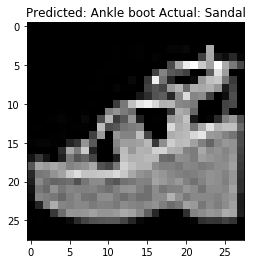

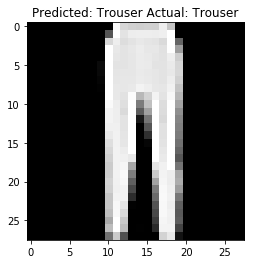

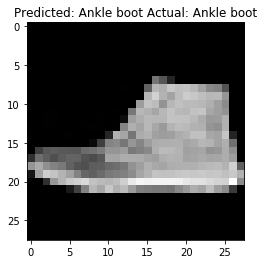

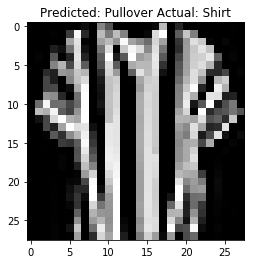

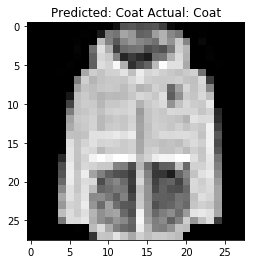

In [20]:
# Evaluate the two layer network with relu
with tf.Session() as sess:
    saver.restore(sess, "./three_layer_model_with_relu.ckpt") 
    X_new_scaled = fash_data.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

for im_index in range(5):
    gen_image(fash_data.test.images[im_index], 
              "Predicted: %s Actual: %s" % (fash_labels[y_pred[im_index]], 
                                           fash_labels[fash_data.test.labels[im_index]])).show()


### Graph Visualization
Let us visualize the graph we have just created using TensorBoard's API
Source code for TensorBoard visualization from: https://gist.github.com/j-min/b37a4c664b2496d284dad989c2c6fb6f

In [21]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
# Show the graph as output below
show_graph(tf.get_default_graph())